# **FACIAL RECOGNITION**
Classify facial expresions analyzing a dataset of images of faces whereby are depicted seven basic emotions: Angry, Disgust, Fear, Happy, Sad, Surprise and Neutral

In [1]:
# General use
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Files
import os 
import tarfile
from google.colab import files

# Visualization
import pandas as pd
import seaborn

# Data analysis
from keras.utils import np_utils

# **1. Data loading**
Let's load them directly from kaggle. To do so, you will have to provide a kaggle.json file that you can download directly from your kaggle account.

In [ ]:
# Install Kaggle
! pip install -q kaggle

# Import files
files.upload()

# Store the json file in a folder for it
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Check if all the data is there
! kaggle datasets list

# Proceed to download the dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

As it's described in the dataset documentation, the data consists of 48x48 pixel grayscale images of faces. These images has been preprocessed already (pretty much centered and occupies about the same amount of space in each image). 

You can find more info about the dataset [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

In [3]:
# Unzip the file
if not os.path.exists('./fer2013/fer2013.csv'):
  !tar -xvf fer2013.tar.gz

# Read the file with pandas
filename = './fer2013/fer2013.csv' 
df = pd.read_csv(filename)
df.head()

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


So far so good! After loading the dataset with pandas we can see the result above to explore the structure of our data. But before discuss about it we will define some methods that will be useful. We are going to create a map with the emotions for an easier representation. 

Also we can see in the dataframe that the image is given by an array of pixels, so it will be useful to create a method to load the training dataset directly, with the format we need it and grouped by emotions.

In [4]:
MAP_EMOTION ={
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}


def load_trainingdata_pixels(dataset, emotions_mp = MAP_EMOTION, img_size = 48, verbose='True'):
  '''
  Loads a list of images through their corresponding array of pixels and returns 
  the training dataset split into values (images) and labels.
  Args:
    dataset: DataFrame with the data
    emotions_mp: Map with the emotions
    img_size: Size image for each one
    verbose: 
  Return:
    train_x: numpy array with the values
    train_y: numpy array with the labels
  '''
  train_x = []
  v_images = np.vstack(dataset['pixels'].values)
  train_y = np.array(dataset['emotion'])

  # Reshape
  v_images = v_images.reshape(-1, img_size, img_size, 1)

  if verbose:
    grouped = dataset.groupby(['emotion']).count()
    for label, emotion in emotions_mp.items():
      cnt = grouped.iloc[label]['pixels']
      print("{} images found of {}".format(cnt, emotion))

  # Load every image
  for i in range (0,len(v_images)):
    train_x.append(v_images[i, :, :, ])

  return np.array(train_x), train_y



Now these methods will display the different plots in the evaluation of results

In [5]:
def plot_acc(history, title = "Model Accuracy"):
  '''
  Shows the accuracy in a plot by every epoch that has been got in a training.
  Args:
    history
    title 
  '''
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()


def plot_loss(history, title = "Model Loss"):
  '''
  Shows the loss in a plot by every epoch that has been got in a training.
  '''
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc = 'upper left')
  plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='MATRIZ CONFUSIÓN',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    @From sklearn
    '''
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observation')
    plt.xlabel('Prediction')

# 1.1. Explore the Data
In the loaded dataset we can see thre columns"emotion","pixels" and "usage".The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. In the last place "usage" column appoint what use is reserved for that image (training, o test)

The training set consists of 28 709 examples. Both, private test and public test consist of 3589 examples (public is used for the leaderboad in the competition and public to determine the winer)


In [6]:
df['Usage'].value_counts()
# df.head()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

Let's proceed to preprocess the data storing it in different datasets (easier use) and make sure there is no null data in it.

In [7]:
# Data Frame for training
training = df[['emotion', 'pixels']][df['Usage'] == 'Training']
training.isnull().sum() # Make sure there is no null data in the selection

# Data Frame for test (private)
test_priv = df[['emotion', 'pixels']][df['Usage'] == 'PrivateTest']
test_priv.isnull().sum()# Make sure there is no null data in the selection

# Data Frame for test (public)
test_pub = df[['emotion', 'pixels']][df['Usage'] == 'PublicTest']
test_pub.isnull().sum()# Make sure there is no null data in the selection

emotion    0
pixels     0
dtype: int64

Split it in **training** and **test** and count up how many images for each catergory we got. Also you might want to check the shapes are consistent.

In [8]:
# Split data train
training['pixels'] = training['pixels'].apply(lambda item: np.fromstring(item, sep = ' ')) # every value in the pixel vector is an item
train_x, train_y = load_trainingdata_pixels(training)

# Check the shape for both
print("\nShape:")
train_y.shape, train_x.shape

3995 images found of Angry
436 images found of Disgust
4097 images found of Fear
7215 images found of Happy
4830 images found of Sad
3171 images found of Surprise
4965 images found of Neutral

Shape:


((28709,), (28709, 48, 48, 1))

# 1.2. Data preview
So, let's have a look to the dataset. I linked each image with the corresponding labeled emotion. In most of the pictures are easy to recognize the facial expression but might be challenging for a computer given some of them are not in the same position, sometimes the face is partially hidden or not all elements in the face are visible.

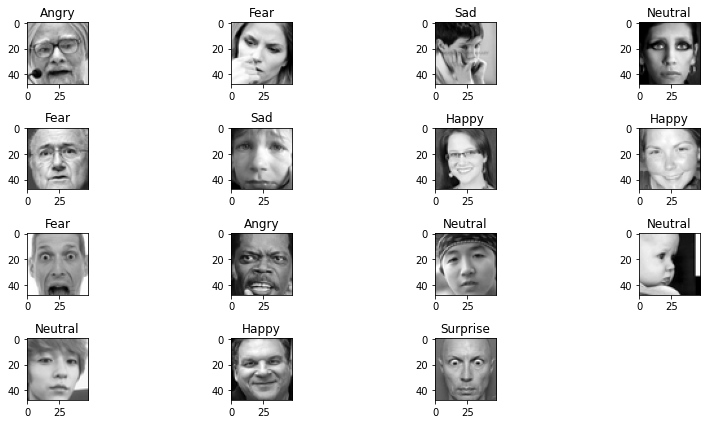

In [9]:
fig = plt.figure(0, figsize=(12,6))
row = 4
col = 4
len(train_x)
for i in range(1, (row*col)):
  ax = fig.add_subplot(row, col, i)
  title = MAP_EMOTION.get(train_y[i])
  ax.title.set_text(title)
  img = train_x[i,:, :, 0]
  plt.imshow(img, cmap = 'gray')
  i = i+1

plt.tight_layout()
plt.show()

# 1.3. Data distribution
We peek at the distribution of the data and we can observe is quite unbalanced, especially '*disgust*'. So we are going to try to ease this by sampling weights in the images inversely proportional to the appearance.

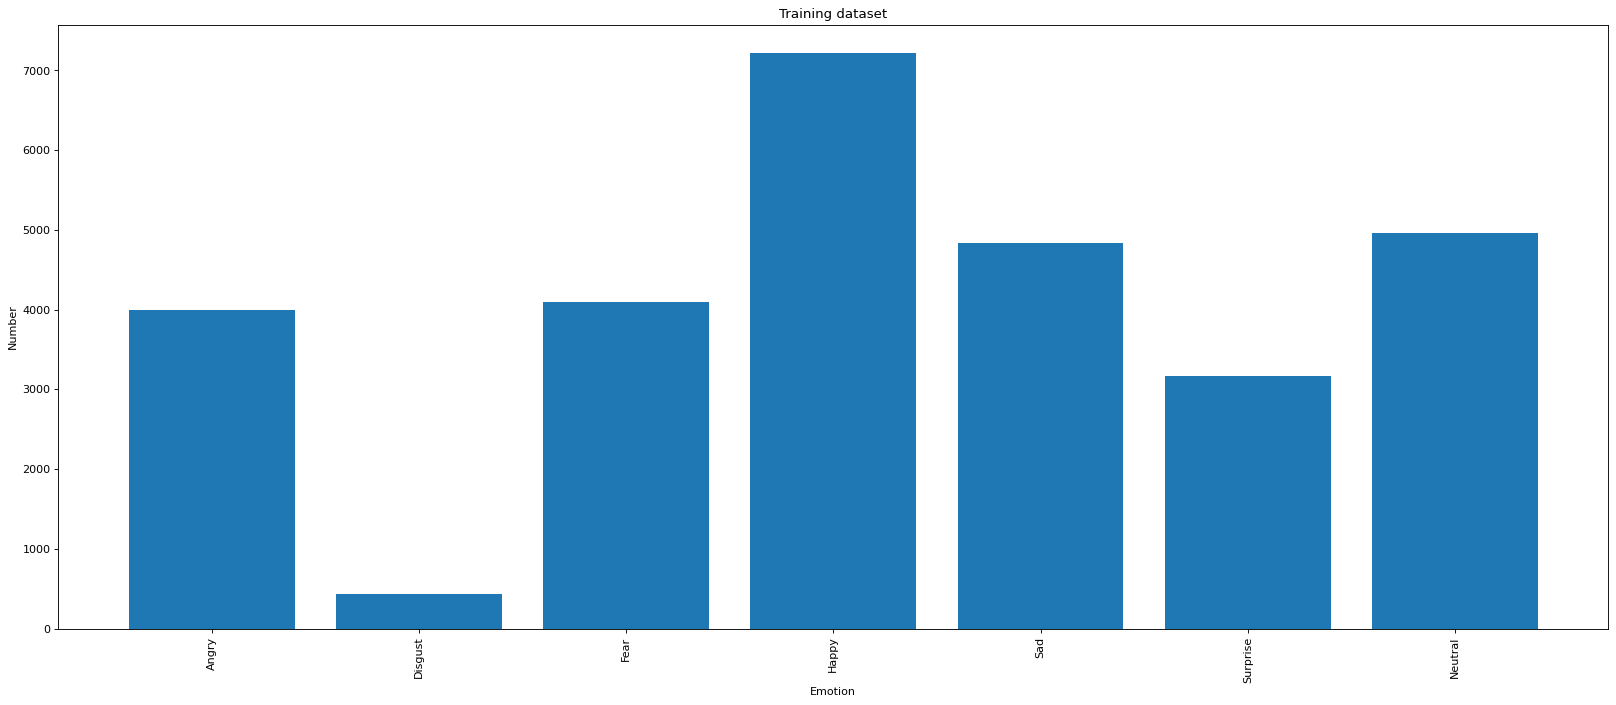

Appearances for every emotion: 
{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}


In [10]:
fig = plt.figure(figsize=(25, 10), dpi= 80, facecolor='w', edgecolor='k')
emotions = [v for v in MAP_EMOTION.values()]

unique, count = np.unique(train_y, return_counts=True)

plt.bar(emotions, count)
plt.xlabel("Emotion")
plt.ylabel("Number")
plt.title("Training dataset")
plt.xticks(emotions, emotions, rotation = 'vertical')
plt.show()

print("Appearances for every emotion: ")
print(dict(zip(unique, count)))

In [13]:
def generate_sample_weights(training_data):
  '''
  Assign and add weight to every sample inversely proportional to the 
  appearance in order to balance the label distribution.
  Args:
    training_data Training data

  Return: 
    sample_weights Corrected weights array for every sample
  '''
  w_training_data = np.argmax(training_data, axis = 1)
  w_unique, w_weights = np.unique(w_training_data, return_counts= True)
  
  # Invert all weights
  w_weights = np.reciprocal(w_weights/(sum(w_weights)))
  dict_weight_lb = dict(zip(w_unique, w_weights))

  sample_weights = [dict_weight_lb[i] for i in w_training_data]
  return np.asarray(sample_weights)


We proceed to split the data into values and labels and check the shape for both.

Moreover since our variables contain label values, they are represented as categorical data. That means a problems as many machine learning algorithms cannot work with categorical data directly: The categories must be converted into numbers. In fact, that was already made by integers (see the MAP_EMOTION i the section 1), however we need a step further.

We can observe there is no need for a ordinal relationship in the categories; In other words, the fact that *Angry* is encoded with 0 has nothing to do with the other emotion *Fear* is encoded by 2. *Angry* is not more or less important that *Fear*; Or *Fear* shouldn't have more weight than *Angry*. These numbers doesn't mean anything among them or whatsoever. That could be misleading if we don't know that in advance, and therefore might lead to a poor performance (or weird results) from the model.

So here it goes to our rescue: **One-hot encoding**

In [11]:
# Split data test into values and labels
test_pub['pixels'] = test_pub['pixels'].apply(lambda item: np.fromstring(item, sep = ' ')) # every value in the pixel vector is an item
test_x = np.vstack(test_pub['pixels'].values) 
test_y = np.array(test_pub['emotion'])

# Check the shape for both
test_x.shape, test_y.shape

((3589, 2304), (3589,))

In [12]:
# One-hot encoding:
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

print("Shape for Y: \n")
train_y.shape, test_y.shape

Shape for Y: 



((28709, 7), (3589, 7))

In [14]:
# Makes easier the turn into CNN
train_x = train_x/255.0
test_x = test_x/255.0
# Test and train for data should have the same shape
test_x = test_x.reshape(-1, 48, 48, 1)
print("Shape for X: \n")

train_x.shape, test_x.shape

Shape for X: 



((28709, 48, 48, 1), (3589, 48, 48, 1))

# **2. Define the model**

We are going now to define the model. Needless to say that we are using an Convolutional Neural Network approach to tackle this problem. This option is widely used to work with images since Neural Networks in general are good to extract the features.

In [15]:
# Machine Learning
import keras
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pickle as pk

In [22]:
num_clases = train_y.shape[1]

model = Sequential()
# CNN 1
model.add(layers.Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape = train_x.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
# model.add(layers.Dropout(0.25))

# CNN 2
model.add(layers.Conv2D(64,3))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(pool_size=(2,2), strides = 2))


# # CNN 3
# model.add(layers.Conv2D(32,3))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation("relu"))

# # CNN 4
# model.add(layers.Conv2D(32,3))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPool2D(pool_size=(2,2), strides = 2))
# model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

# Dense
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))

# Dense
model.add(layers.Dense(num_clases))
model.add(layers.Activation("softmax"))



# Summary
model.summary()      

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_13 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)       

# Compile

In [23]:
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1)
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = opt, 
              metrics=['acc']
              )



In [ ]:
checkpoint_path = 'face_model_weights.h5'
saved_model_path = 'face_model.h5'

# Define the callbacks
callbacks = [EarlyStopping(monitor = 'val_loss' , patience = 10),
             ModelCheckpoint(filepath = checkpoint_path,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True)]

# Run the model
epochs = 50
batch_size = 100
# validation_data = (train_x, train_y)
# test_data = (test_x, test_y)

history = model.fit(train_x, train_y,
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    # sample_weight = generate_sample_weights(train_y),
                    validation_split = 0.2,
                    callbacks = callbacks
                    )

model.save('model_facialEmotion.h5')

Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 2.0614 - acc: 0.2713
Epoch 00001: val_acc improved from -inf to 0.35127, saving model to face_model_weights.h5
230/230 [==============================] - 364s 2s/step - loss: 2.0614 - acc: 0.2713 - val_loss: 1.6638 - val_acc: 0.3513
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 1.6873 - acc: 0.3728
Epoch 00002: val_acc improved from 0.35127 to 0.41414, saving model to face_model_weights.h5
230/230 [==============================] - 365s 2s/step - loss: 1.6873 - acc: 0.3728 - val_loss: 1.5188 - val_acc: 0.4141
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 1.5133 - acc: 0.4311
Epoch 00003: val_acc improved from 0.41414 to 0.45733, saving model to face_model_weights.h5
230/230 [==============================] - 365s 2s/step - loss: 1.5133 - acc: 0.4311 - val_loss: 1.4485 - val_acc: 0.4573
Epoch 4/50
230/230 [==============================] - ETA: 0s - loss: 1.3865 - acc: 0

In [ ]:
model.load_weights('face_model_weights.h5')

In [ ]:
# Plot the data
plot_acc(history)
plot_loss(history)

# Evaluate the model with test
loss, acc = model.evaluate(test_x, test_y, verbose = 2)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(acc))

In [ ]:
# # Predict the values from the validation dataset
# Y_pred = model_1.predict(Xn_t)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# # Convert validation observations to one hot vectors
# Y_true = np.argmax(yn_t, axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# # plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = list(MAP_CHARACTERS.values()))

# Predict the values from the validation dataset
y_pred = model.predict(test_x)
# Convert predictions classes to one hot vectors
y_pred_lb = np.argmax(y_pred, axis = -1)